# Взаимодействие с клиентами сети фитнес-центров

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. 

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Чтобы бороться с оттоком, отдел по работе с клиентами перевёл в электронный вид множество клиентских анкет. Наша задача — провести анализ и подготовить план действий по удержанию клиентов. 

В процессе выполнения необходимо осуществить следующие действия:
- загрузить данные, ознакомиться с ними;
- рассмотреть распределение признаков для тех, кто ушёл и тех, кто остался;
- рассмотреть матрицу корреляций;
- разбить данные на обучающую и валидационную выборки;
- обучить модель двумя способами (логистической регрессией и случайным лесом) и сравнить их на основании метрик;
- обучить модель кластеризации на основании алгоритма K-Means и спрогнозировать кластеры клиентов.

## Знакомство с данными

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/datasets/gym_churn.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


### Вывод
Ознакомились с данными. Пропусков нет. Категориальные данные преобразованы. Для удобства поправим заголовки столбцов и можно приступать к дальнейшим действиям.

## Исследовательский анализ данных

In [3]:
df.columns = [x.lower() for x in df.columns]
df['month_to_end_contract'] = df['month_to_end_contract'].astype('int')
df.duplicated().sum()

0

In [4]:
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [5]:
df.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


При разделении клиентов на тех кто ушёл и кто остался видно, что у тех кто в оттоке ниже доля пришедших по акции "Приведи друга", в среднем короче срок абонемента, меньше посещают групповые занятия, меньше тратят на другие услуги фитнес-центра, меньшее время являются клиентами фитнес-центра. 

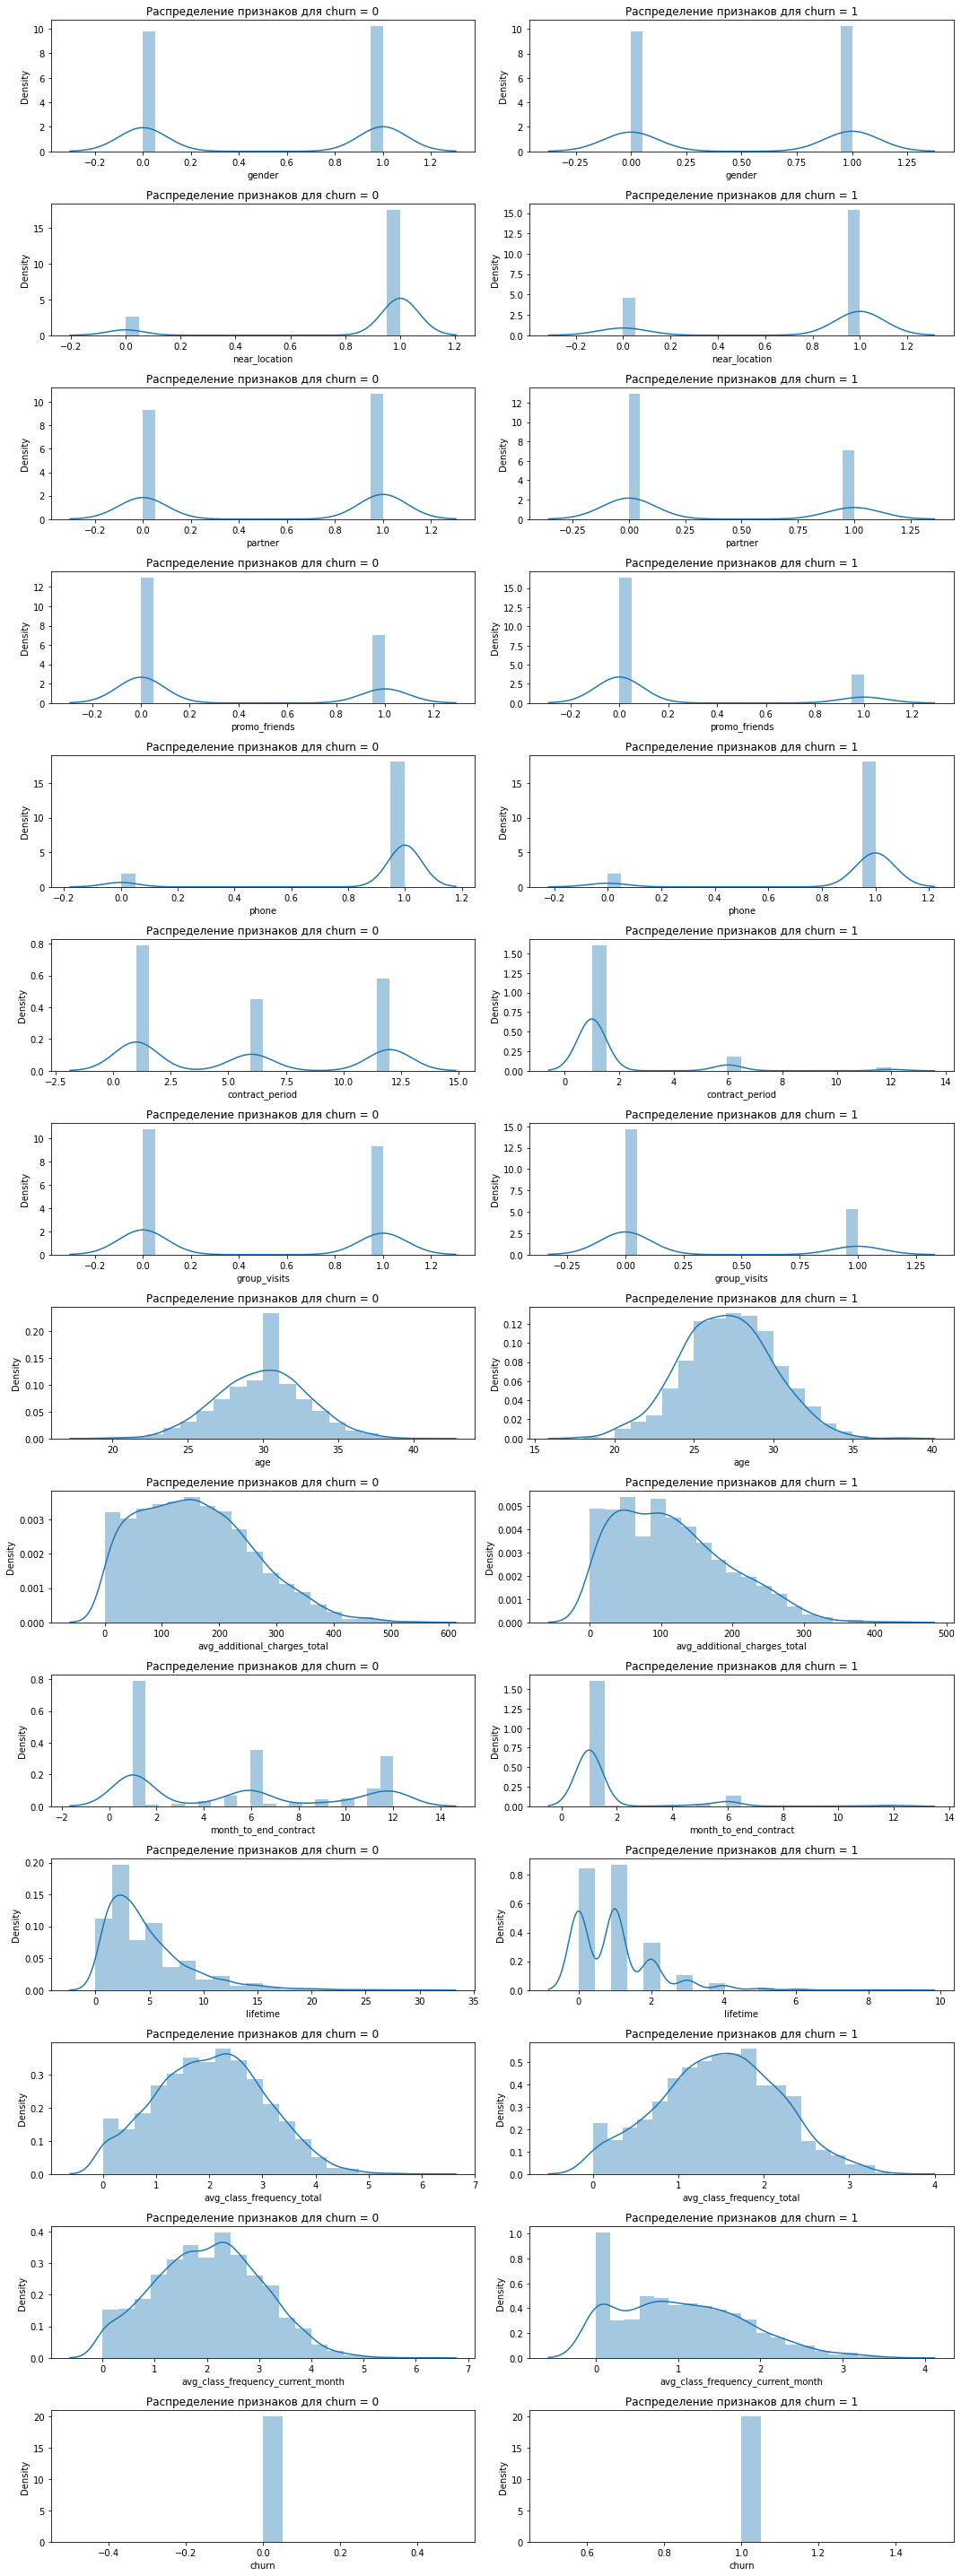

In [6]:
plt.figure(figsize=(15, 40))

for i, churn_var in enumerate(df['churn'].unique()):
    for x, feature in enumerate(df.columns):
        sns.distplot(df.query('churn == @churn_var')[feature], bins=20, ax=plt.subplot(14, 2, (x*2) + i + 1))
        plt.title('Распределение признаков для churn = {}'.format(churn_var))

plt.tight_layout()        
plt.show()       

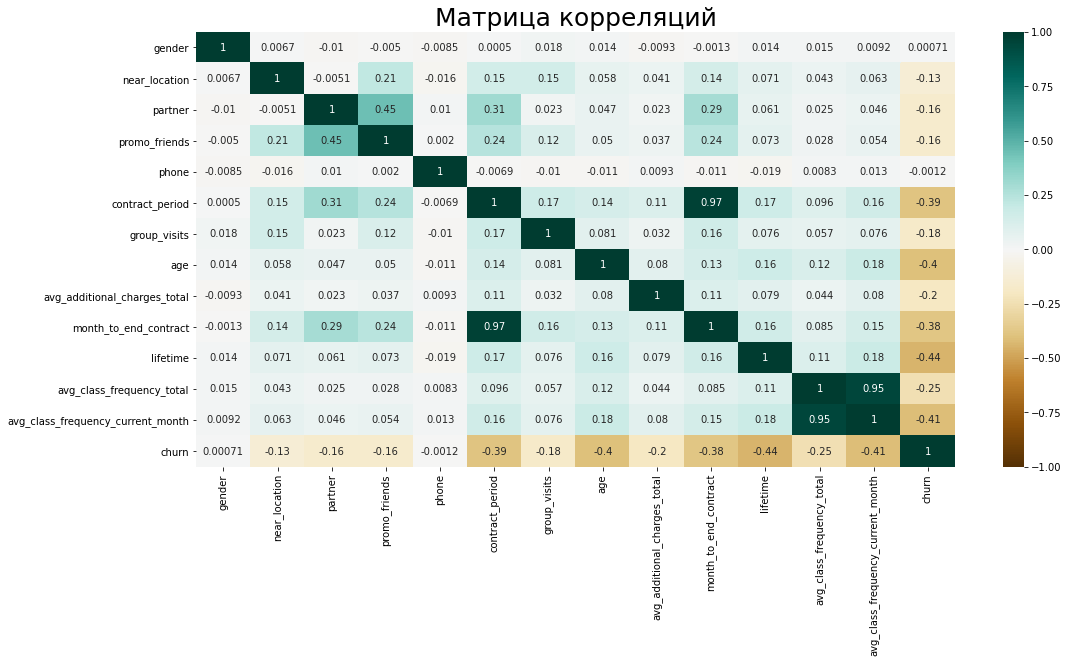

In [7]:
plt.figure(figsize=(17,8))
sns.heatmap(df.corr(),  vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.title('Матрица корреляций', fontsize=25)
plt.show()

### Вывод
В отток, в основном, попадают клиенты, которые не так давно посетили фитнес-центр в первый раз.

## Построение модели прогнозирования оттока клиентов

Смотрим соотношение классов целевой переменной в наборе данных.

In [8]:
df['churn'].value_counts()

0    2939
1    1061
Name: churn, dtype: int64

Соотношение неоднородно: 75% на 25% оставшихся к ушедшим.

In [9]:
# Разделение данных на признаки (X) и целевую переменную (y)
X = df.drop('churn', axis=1)
y = df['churn']
# Разделение модели на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

models = [LogisticRegression(random_state=0, solver='liblinear'), RandomForestClassifier(random_state=0)]

In [10]:
def ml(X_train, X_test, y_train, y_test):
    for m in models:
        model = m
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print('Метрики для модели:{}'.format(m))
        print('\tAccuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
        print('\tPrecision: {:.2f}'.format(precision_score(y_test, predictions)))
        print('\tRecall: {:.2f}'.format(recall_score(y_test, predictions))) 
        print('\tF_1: {:.2f}'.format(f1_score(y_test, predictions)))

In [11]:
ml(X_train, X_test, y_train, y_test)

Метрики для модели:LogisticRegression(random_state=0, solver='liblinear')
	Accuracy: 0.93
	Precision: 0.86
	Recall: 0.83
	F_1: 0.85
Метрики для модели:RandomForestClassifier(random_state=0)
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.82
	F_1: 0.83


Так как соотношение классов не одинаково, не стоит сильно опираться на метрику accuracy. Сравнивая остальные метрики, видим, что модель логистической регрессии показывает более лучшие результаты.

### Вывод
Модель прогнозирования, обученная логистической регрессией, показывает более лучшие результаты по сравнению с моделью, обученной случайным деревом. Сводная метрика F_1 для логистической регрессии: 0.85, для случайного дерева: 0.83.

## Кластеризация клиентов

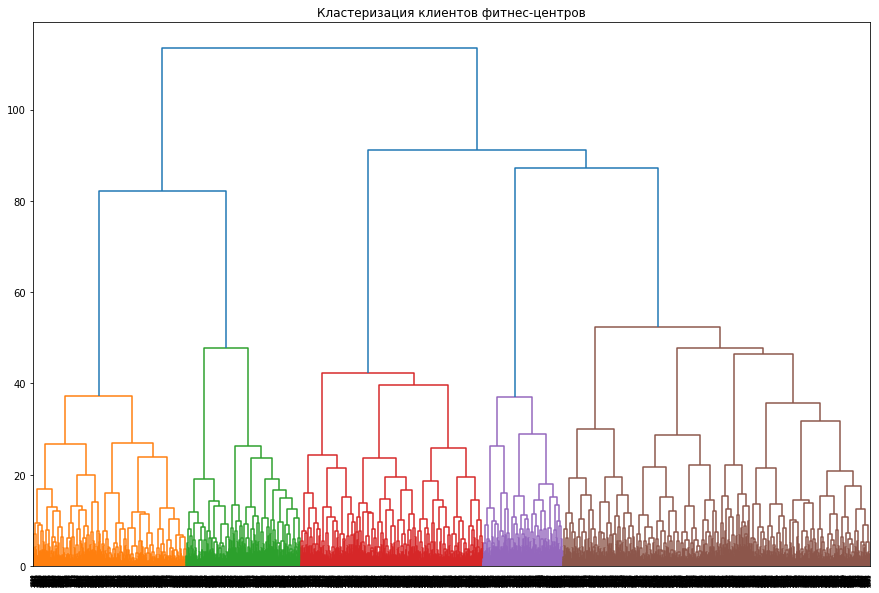

In [12]:
# Стандартизация данных
sc = StandardScaler()
df_sc = sc.fit_transform(df)
# Сохранение таблицы и визуализация
linked = linkage(df_sc, method = 'ward')

plt.figure(figsize=(15,10))
dendrogram(linked, orientation='top')
plt.title('Кластеризация клиентов фитнес-центров')
plt.show() 

In [13]:
# Задаём модель k-means
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(df_sc)

df['cluster'] = labels
df.groupby('cluster').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster,,,,,,,,,,,,,,
0,0.503676,0.000000,0.459559,0.075368,0.917279,2.069853,0.211397,28.522059,132.741216,1.950368,2.757353,1.706629,1.515890,0.450368
1,0.492829,0.936115,0.764016,0.534550,0.919166,10.447197,0.516297,29.962190,161.853561,9.477184,4.833116,2.788103,2.786919,0.007823
2,0.507917,1.000000,0.323995,0.213155,0.903776,1.546894,0.287454,26.926918,113.173051,1.500609,1.031669,1.449720,1.037592,0.961023
3,0.521186,0.996610,0.282203,0.208475,0.904237,1.882203,0.452542,30.237288,157.988625,1.794915,4.923729,2.203432,2.207359,0.003390
4,0.518895,0.968023,0.744186,0.526163,0.873547,8.859012,0.534884,29.728198,162.907495,8.155523,4.411337,0.957744,0.943967,0.024709


Самое заметное отличие: в признаке churn только у одной группы (2) значение очень близко к 1. В этой же группе самое низкое значение lifetime, contract_period, month_to_end_contract, то есть сюда входят новые клиенты фитнес-центров. И только у этой группы фитнес-центр находится в районе проживания или работы, при этом низкие показатели partner и promo_friends, что показывает, что в первую очередь их привлекло расположение фитнес-центра.    

Группа №0 характеризуется почти равным соотношением оставшихся к оттоку, большим lifetime чем во второй группе.

В остальных группах очень низкий уровень оттока, этих клиентов можно отнести к постоянным (более 4-х месяцев с момента первого посещения), высокая средняя суммарная выручка от других услуг фитнес-центра. 

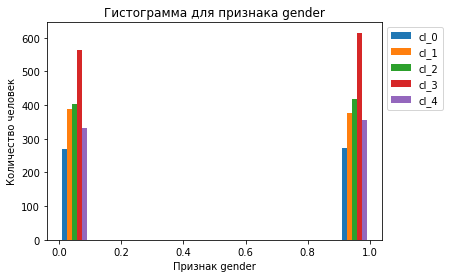

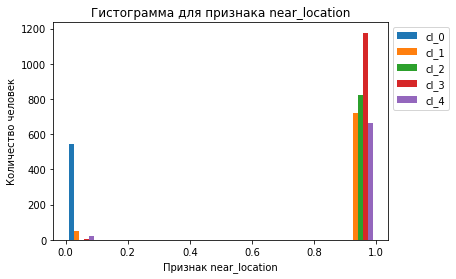

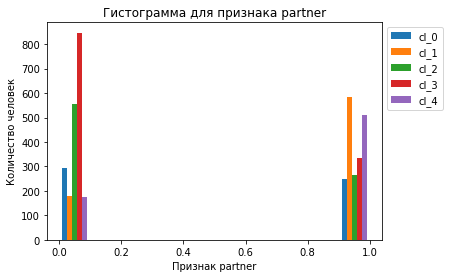

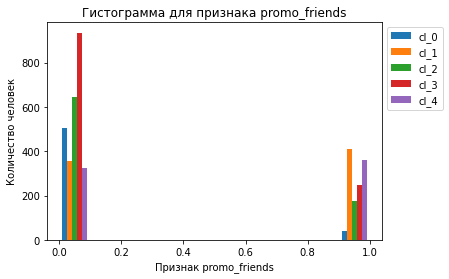

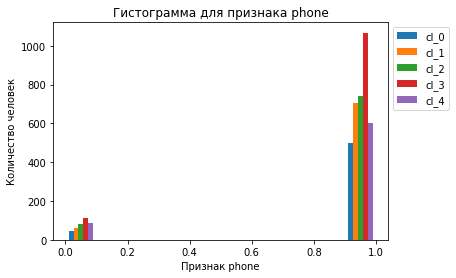

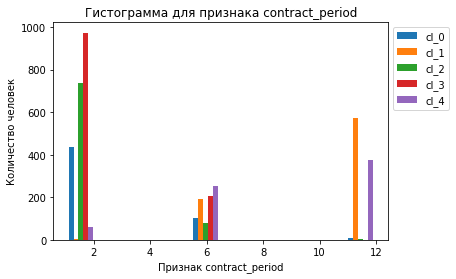

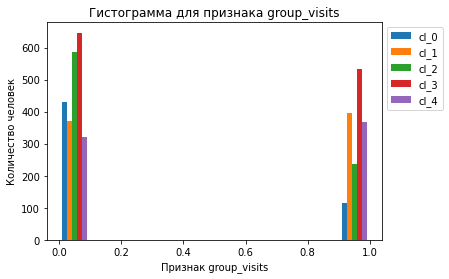

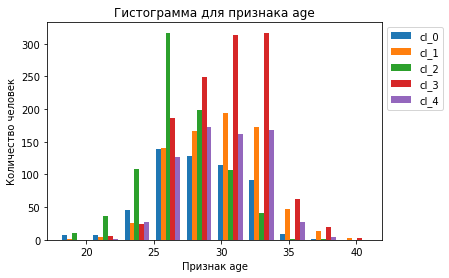

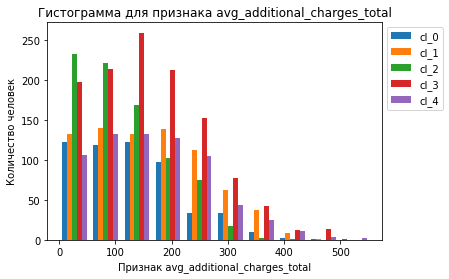

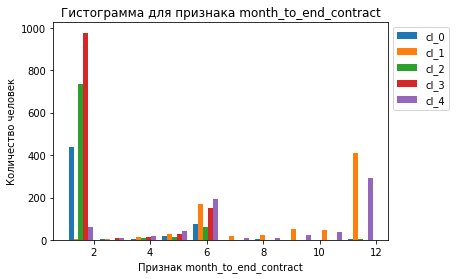

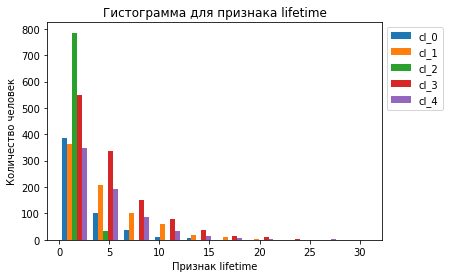

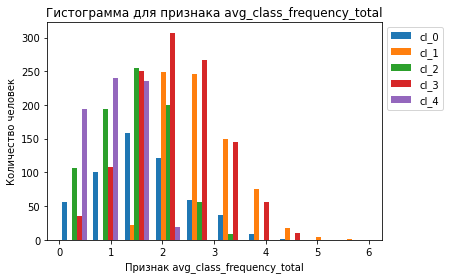

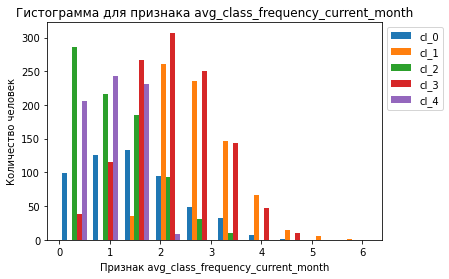

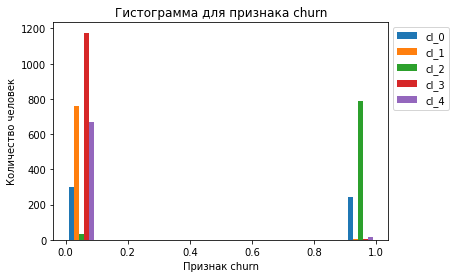

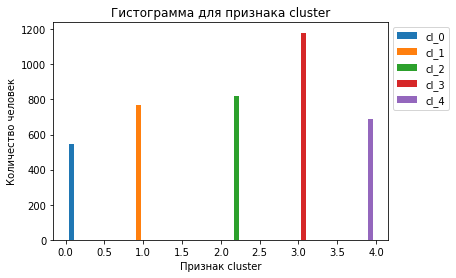

In [15]:
for column in df.columns:
    cl_0 = df[df['cluster'] == 0][column]
    cl_1 = df[df['cluster'] == 1][column]
    cl_2 = df[df['cluster'] == 2][column]
    cl_3 = df[df['cluster'] == 3][column]
    cl_4 = df[df['cluster'] == 4][column]
    plt.hist([cl_0, cl_1, cl_2, cl_3, cl_4], bins=10, label=['cl_0', 'cl_1', 'cl_2', 'cl_3', 'cl_4'])
    plt.legend(loc=2, bbox_to_anchor=(1,1))
    plt.title(f'Гистограмма для признака {column}')
    plt.xlabel(f'Признак {column}')
    plt.ylabel('Количество человек')
    plt.show()

После визуализации можно дополнить предыдущие выводы:
- В группу №0 входят клиенты, у которых фитнес-центр расположен не рядом с домом или работой. Почти все пришли по акции "Приведи друга".
- В группах №0 и 2 менее трети клиентов посещают групповые занятия, в остальных группах этот показатель около 50%.
- У групп № 0, 2, 4 большая часть клиентов посетили фитнес-центр менее 2 раз за предыдущий месяц.

### Вывод
- Самые большие доли оттока у кластеров 2 и 0 (96% и 45%). Самый низкий отток в кластерах 1 и 3. 
- В "проблемных" кластерах самый низкий средний lifetime.
- Также эти кластеры отличаются самой низкой долей клиентов, посещающих групповые занятия и низкими тратами на другие услуги фитнес-центра.

## Общие выводы и рекомендации
В процессе выполнения провели следующие действия:
- загрузили данные, ознакомились с ними;
- рассмотрели распределение признаков для тех, кто ушёл и тех, кто остался;
- разбили данные на обучающую и валидационную выборки;
- обучили модель двумя способами (логистической регрессией и случайным лесом) и сравнили их на основании метрик;
- обучили модель кластеризации на основании алгоритма K-Means и спрогнозировали кластеры клиентов.

Нами установлено:
- В отток, в основном, попадают клиенты, которые не так давно посетили фитнес-центр в первый раз.
- Модель прогнозирования, обученная логистической регрессией, показывает более лучшие результаты по сравнению с моделью, обученной случайным деревом.
- Самые большие доли оттока у кластеров 2 и 0 (96% и 45%). Самый низкий отток в кластерах 1 и 3.
- В "проблемных" кластерах самый низкий средний lifetime. Также эти кластеры отличаются самой низкой долей клиентов, посещающих групповые занятия и низкими тратами на другие услуги фитнес-центра.

Рекомендации:
Целевые кластеры для работы по снижению оттока: 0 и 2. Отток происходит в первые месяцы после начала посещения фитнес-центра (от 1 месяца до трёх в зависимости от кластера). Установили, что в этих кластерах самые низкие доли клиентов, посещающих групповые занятия и низкие траты на другие услуги фитнес-центра. Вероятно, имеют место пробелы в информировании клиентов о всех сервисах и возможностях фитнес-центра (рекламная информация, информирование внутри фитнес-центра). В других кластерах также есть новички, но там большая доля приходит по акции "Приведи друга", которые дают всю информацию. 
- Скорректировать рекламные материалы.
- Информирование внутри фитнес-центра: дни открытых дверей, ознакомительная экскурсия для новых клиентов.
- Продолжение работы с акцией "Приведи друга".